In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import time
import random
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline as SkPipeline
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from imblearn.pipeline import Pipeline as ImbPipeline # Replaces sklearn Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

# load the dataset and fix values

In [2]:
# Use the GPU
if torch.backends.mps.is_available():
    print("MPS device is available.")
    device = torch.device("mps")
elif torch.cuda.is_available():
    print("CUDA device is available.")
    device = torch.device("cuda")
else:
    print("No GPU acceleration available.")
    device = torch.device("cpu")

# Fix the seed to have deterministic behaviour
def fix_random(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True  # slower

SEED = 1337
fix_random(SEED)

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

DATASET_PATH = "dataset_train/dataset.csv"
dataset = pd.read_csv(DATASET_PATH, delimiter=",")

print(f"Shape of the dataset: {dataset.shape}")
duplicates = dataset[dataset.duplicated()]
print(f"Number of duplicates in the dataset: {duplicates.shape[0]}")

MPS device is available.
Shape of the dataset: (148301, 145)
Number of duplicates in the dataset: 0


## split the dataset

In [3]:
X = dataset.drop(columns=["grade"])
y = dataset["grade"].map({"A": 6, "B": 5, "C": 4, "D": 3, "E": 2, "F": 1, "G": 0})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [4]:
class NumericExtractor(BaseEstimator, TransformerMixin):
    """Extracts integers from strings using regex"""

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for col in X.columns:
            X[col] = X[col].astype(str).str.extract(r"(\d+)").astype(float)
        return X

class CyclicalDateEncoder(BaseEstimator, TransformerMixin):
    """Converts mm-yyyy to year + sine/cosine month encoding."""

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for col in X.columns:
            # errors="coerce" turns unparseable data/NaNs into NaT
            date_series = pd.to_datetime(X[col], format="%b-%Y", errors="coerce")
            # If date is NaT, these become NaN, which we handle in the pipeline later
            angle = 2 * np.pi * date_series.dt.month / 12

            X[f"{col}_year"] = date_series.dt.year
            X[f"{col}_month_sin"] = np.sin(angle)
            X[f"{col}_month_cos"] = np.cos(angle)
            
            X.drop(columns=[col], inplace=True)
        return X
    
class BinaryModeEncoder(BaseEstimator, TransformerMixin):
    """"Encodes 0 if value is mode, 1 if not"""
    def __init__(self):
        self.modes_ = {}

    def fit(self, X, y=None):
        # Calculate mode for each column and store it
        for col in X.columns:
            self.modes_[col] = X[col].mode()[0]
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col, mode in self.modes_.items():
            # Apply: 1 if NOT the mode (least frequent), 0 if mode
            X_copy[col] = (X_copy[col] != mode).astype(int)
        return X_copy
    
class HighMissingDropper(BaseEstimator, TransformerMixin):
    """Drops columns with high missing percentage. Fits only on training data."""
    
    def __init__(self, threshold=20):
        self.threshold = threshold
        self.cols_to_drop_ = []

    def fit(self, X, y=None):
        # Calculate missing percentages only on training data
        missing_percentages = X.isna().mean() * 100
        self.cols_to_drop_ = missing_percentages[missing_percentages > self.threshold].index.tolist()
        return self

    def transform(self, X):
        X = X.copy()
        return X.drop(columns=self.cols_to_drop_)

In [5]:
redundant_cols = ['loan_title', "borrower_address_state"]
binary_cols = ["loan_payment_plan_flag", "listing_initial_status", "application_type_label",
               "hardship_flag_indicator", "disbursement_method_type", "debt_settlement_flag_indicator"]
one_hot_encoding_cols = ["borrower_housing_ownership_status", "borrower_income_verification_status",
                       "loan_status_current_code", "loan_purpose_category"]
extract_fields = ["loan_contract_term_months", "borrower_profile_employment_length"]
date_fields = ["loan_issue_date", "credit_history_earliest_line", "last_payment_date", "last_credit_pull_date"]
embed_column = ['borrower_address_zip']

In [6]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import OrdinalEncoder
from sklearn.utils.class_weight import compute_class_weight

numeric_pipe = SkPipeline([
    ('extract', NumericExtractor()),
    ('impute', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipe = SkPipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ohe', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

date_pipe = SkPipeline([
    ('cyclical', CyclicalDateEncoder()),
    ('impute', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()) # scaling is needed for the year, not for sin/cos
])

binary_pipe = SkPipeline([
    ('binary_enc', BinaryModeEncoder()), 
    ('impute', SimpleImputer(strategy='most_frequent'))
])

# Main pipeline WITHOUT the embed column
preprocessor = ColumnTransformer([
    ('num_pipe', numeric_pipe, extract_fields),
    ('cat_pipe', categorical_pipe, one_hot_encoding_cols),
    ('date_pipe', date_pipe, date_fields),
    ('bin_pipe', binary_pipe, binary_cols),
    ('drop_redundant', 'drop', redundant_cols),
], remainder=SimpleImputer(strategy='median'))

numerical_pipeline = SkPipeline([
    ('dropper', HighMissingDropper(threshold=20)),
    ('prep', preprocessor),
])

zip_pipeline = SkPipeline([
    ('dropper', HighMissingDropper(threshold=20)),
    ('impute', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ordinal', OrdinalEncoder(dtype=np.int64, handle_unknown='use_encoded_value', unknown_value=-1))
])

numerical_columns = [c for c in X_train.columns if c not in embed_column]

X_numerical_train = numerical_pipeline.fit_transform(X_train[numerical_columns], y_train)
X_zip_train = zip_pipeline.fit_transform(X_train[embed_column]).squeeze()

X_numerical_test = numerical_pipeline.transform(X_test[numerical_columns])
X_zip_test = zip_pipeline.transform(X_test[embed_column]).squeeze()

print(X_numerical_train.shape)
print(X_zip_train.shape)
print(y_train.shape)



(118640, 121)
(118640,)
(118640,)


In [7]:
# 1. Create tensors separately
# Numerical features -> Float32
X_num_train_tensor = torch.tensor(X_numerical_train, dtype=torch.float32)
X_num_test_tensor = torch.tensor(X_numerical_test, dtype=torch.float32)

# Zip codes (indices) -> Long (Integers) required for nn.Embedding
X_zip_train_tensor = torch.tensor(X_zip_train, dtype=torch.long)
X_zip_test_tensor = torch.tensor(X_zip_test, dtype=torch.long)

# Targets -> Long (standard for Classification)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# 2. Pass ALL tensors to TensorDataset
# The dataset will now yield a tuple of 3 items: (numerical_data, zip_data, label)
train_dataset = TensorDataset(X_num_train_tensor, X_zip_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_num_test_tensor, X_zip_test_tensor, y_test_tensor)

# 3. Create DataLoaders
batch_size = 1024
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 4. Handle Class Weights (unchanged)
y_train_np = y_train_tensor.numpy()
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_np),
    y=y_train_np
)

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

print(f"Computed Class Weights: {class_weights_tensor}")

Computed Class Weights: tensor([3.4823, 2.8158, 1.7534, 0.9966, 0.5713, 0.5614, 0.7984],
       device='mps:0')


In [8]:
print(X_num_train_tensor.shape)
print(X_zip_train_tensor.shape)

torch.Size([118640, 121])
torch.Size([118640])


In [9]:
class FeedForwardModel(nn.Module):
    def __init__(self, cont_dim, hidden_dims=[128, 64, 32]):
        super().__init__()
        zip_embed_dim = 64
        num_zip_codes = 883 # borrower_address_zip 882 different values + 1 missing
        self.emb = nn.Embedding(num_zip_codes, zip_embed_dim)
        
        self.input_dim = cont_dim + zip_embed_dim

        layers = []
        in_dim = self.input_dim
        
        for h_dim in hidden_dims:
            layers.append(nn.Linear(in_dim, h_dim))
            layers.append(nn.BatchNorm1d(h_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.2))
            in_dim = h_dim
        
        self.mlp = nn.Sequential(*layers)
        
        # Projects the last hidden layer to the number of classes (7)
        self.head = nn.Linear(hidden_dims[-1], 7)

    def forward(self, X_cont, X_zip):
        # Embed zip codes
        # Result shape: (Batch_Size, zip_embed_dim)
        zip_embedded = self.emb(X_zip)
        
        # Concatenate continuous features + embeddings
        # Result shape: (Batch_Size, cont_dim + zip_embed_dim)
        x = torch.cat([X_cont, zip_embedded], dim=1)
        
        # Pass through MLP features
        x = self.mlp(x)
        
        # Final classification
        return self.head(x)

In [10]:
cont_dim = X_num_train_tensor.shape[1] 

print(f"Training on: {device}")

model = FeedForwardModel(cont_dim=cont_dim).to(device)
print(model)

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, min_lr=1e-6)

Training on: mps
FeedForwardModel(
  (emb): Embedding(883, 64)
  (mlp): Sequential(
    (0): Linear(in_features=185, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.2, inplace=False)
  )
  (head): Linear(in_features=32, out_features=7, bias=True)
)


In [11]:
epochs = 200
best_test_loss = float('inf')  # Track best loss for checkpointing

# History for plotting later
history = {'train_loss': [], 'test_loss': [], 'test_acc': [], 'test_f1': [], 'test_bal_acc': []}

for epoch in range(epochs):
    # --- TRAIN ---
    model.train()
    running_train_loss = 0.0
    
    for i, (batch_cont, batch_zip, batch_labels) in enumerate(train_loader):
        batch_cont, batch_zip, batch_labels = batch_cont.to(device), batch_zip.to(device), batch_labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_cont, batch_zip)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item()
    
    avg_train_loss = running_train_loss / len(train_loader)
    
    # --- EVALUATE ---
    model.eval()
    running_test_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch_cont, batch_zip, batch_labels in test_loader:
            batch_cont, batch_zip, batch_labels = batch_cont.to(device), batch_zip.to(device), batch_labels.to(device)
            
            outputs = model(batch_cont, batch_zip)
            loss = criterion(outputs, batch_labels)
            running_test_loss += loss.item()
            
            # Store predictions and labels for sklearn metrics
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(batch_labels.cpu().numpy())

    # Calculate Epoch Metrics
    avg_test_loss = running_test_loss / len(test_loader)
    
    # Sklearn metrics (computed on the whole test set at once)
    epoch_acc = accuracy_score(all_labels, all_preds) * 100
    epoch_bacc = balanced_accuracy_score(all_labels, all_preds) * 100
    epoch_f1 = f1_score(all_labels, all_preds, average='weighted') * 100
    
    # Update History
    history['train_loss'].append(avg_train_loss)
    history['test_loss'].append(avg_test_loss)
    history['test_acc'].append(epoch_acc)
    history['test_f1'].append(epoch_f1)
    history['test_bal_acc'].append(epoch_bacc)

    # --- UPGRADE 2: Scheduler Step ---
    # Update LR based on test loss
    scheduler.step(avg_test_loss)
    
    current_lr = optimizer.param_groups[0]['lr']
    
    # --- UPGRADE 3: Save Best Model ---
    if avg_test_loss < best_test_loss:
        best_test_loss = avg_test_loss
        torch.save(model.state_dict(), 'best_model.pth')
        save_msg = "-> Model Saved!"
    else:
        save_msg = ""

    print(f"Epoch [{epoch+1}/{epochs}] LR: {current_lr} | "
          f"Train Loss: {avg_train_loss:.4f} | Test Loss: {avg_test_loss:.4f} | "
          f"B-Acc: {epoch_bacc:.2f}% | F1: {epoch_f1:.2f}% {save_msg}")

print("Training Complete. Best model loaded.")
# Load the best weights back into the model
model.load_state_dict(torch.load('best_model.pth'))

Epoch [1/200] LR: 0.001 | Train Loss: 1.7993 | Test Loss: 1.5683 | B-Acc: 32.95% | F1: 30.93% -> Model Saved!
Epoch [2/200] LR: 0.001 | Train Loss: 1.4898 | Test Loss: 1.3432 | B-Acc: 41.99% | F1: 44.01% -> Model Saved!
Epoch [3/200] LR: 0.001 | Train Loss: 1.3667 | Test Loss: 1.2789 | B-Acc: 45.92% | F1: 48.90% -> Model Saved!
Epoch [4/200] LR: 0.001 | Train Loss: 1.2958 | Test Loss: 1.1757 | B-Acc: 50.55% | F1: 55.32% -> Model Saved!
Epoch [5/200] LR: 0.001 | Train Loss: 1.2533 | Test Loss: 1.1232 | B-Acc: 54.13% | F1: 59.02% -> Model Saved!
Epoch [6/200] LR: 0.001 | Train Loss: 1.2142 | Test Loss: 1.1123 | B-Acc: 54.26% | F1: 60.19% -> Model Saved!
Epoch [7/200] LR: 0.001 | Train Loss: 1.1908 | Test Loss: 1.0676 | B-Acc: 56.44% | F1: 60.97% -> Model Saved!
Epoch [8/200] LR: 0.001 | Train Loss: 1.1594 | Test Loss: 1.0662 | B-Acc: 56.57% | F1: 60.53% -> Model Saved!
Epoch [9/200] LR: 0.001 | Train Loss: 1.1462 | Test Loss: 1.0519 | B-Acc: 56.63% | F1: 58.76% -> Model Saved!
Epoch [10/

<All keys matched successfully>

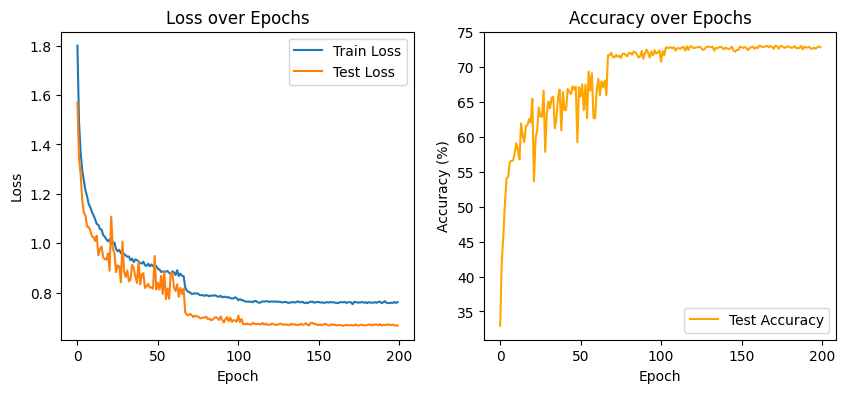

Training history saved to feedforward_training_history.csv


In [12]:
plt.figure(figsize=(10, 4))

# --- Subplot 1: Loss ---
plt.subplot(1, 2, 1)
# Plot Train Loss
plt.plot(history["train_loss"], label='Train Loss')
# Plot Test Loss separately
plt.plot(history["test_loss"], label='Test Loss') 
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend() # This is important to show the labels defined above

# --- Subplot 2: Accuracy ---
plt.subplot(1, 2, 2)
plt.plot(history["test_bal_acc"], label='Test Accuracy', color='orange')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.show()

# 1. Convert history dict to DataFrame
df_history = pd.DataFrame(history)

# 2. Add an 'Epoch' column for clarity (1-based index)
df_history['epoch'] = range(1, len(df_history) + 1)

# 3. Save to CSV
csv_filename = 'feedforward_training_history.csv'
df_history.to_csv(csv_filename, index=False)
print(f"Training history saved to {csv_filename}")

In [13]:
# 1. Set model to evaluation mode
model.eval()

# 2. Disable gradient calculation
with torch.no_grad():
    # Move BOTH test tensors to the correct device
    # Note: These variable names match the tensors we created earlier
    X_num_test_gpu = X_num_test_tensor.to(device)
    X_zip_test_gpu = X_zip_test_tensor.to(device)
    
    # 3. Forward pass with BOTH inputs
    outputs = model(X_num_test_gpu, X_zip_test_gpu)
    
    # 4. Get predicted classes
    # index 1 gives the indices of the max values (the predicted class labels)
    _, y_pred_tensor = torch.max(outputs, 1)
    
    # 5. Convert to NumPy
    y_pred = y_pred_tensor.cpu().numpy()

# 6. Calculate metrics
# Use y_test (original pandas Series) or y_test_tensor.numpy()
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")

bacc = balanced_accuracy_score(y_test, y_pred)
print(f"Balanced Accuracy: {bacc:.4f}")

f1 = f1_score(y_test, y_pred, average="weighted")
print(f"F1 score: {f1:.4f}")

Accuracy: 0.7680
Balanced Accuracy: 0.7298
F1 score: 0.7675
